# Data Wrangling and Analysis with Twitter data


### Load libraries

In [1]:

import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import json
from datetime import datetime

% matplotlib inline

### Gather

###### The WeRateDogs Twitter archive

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

###### The tweet image predictions
It contains dog breed predictions from a neural network classifier.

In [4]:
#programmatically download the image predictions file
images_folder = 'image_predictions'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)
response

with open(os.path.join(images_folder,
                      url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [5]:
# Load the image predictions into a dataframe
image_pred = pd.read_csv('image_predictions/image-predictions.tsv', sep='\t')
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


###### Additional data from Twitter API

Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy access library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with tweet ID and the additional data.

In [6]:
# After setting up a Twitter application, this code will create an API object that can be used to gather Twitter data.

consumer_key ='6QYfY0slJ0tqQkPAJxU7Ob8aU'
consumer_secret='jKkRWZVoKBmnY4ilccOoxyhhONO1NeMZoWWmSyaUDc3hkVoQlY'
access_token='1179784035368722432-V497xP1WJRTx6ctjkV5DLY7laQZLuR'
access_secret='YXnHpHXboLLO2CUOW1zsSWuiRnOv1MqKrSd6NES27nR7Z'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api= tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True )

In [7]:
tweet_ids=list(twitter_archive.tweet_id)
tweet_data=[]
deleted_tweet_id=[]
for tweet_id in tweet_ids:
    try:
        tweet=api.get_status(tweet_id,tweet_mode='extended',wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
        tweet_info=tweet._json
        tweet_data.append(tweet_info)
        
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        deleted_tweet_id.append(tweet_id)
        

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 _ [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 _ [{'code

In [10]:
tweet_ids=list(twitter_archive.tweet_id)
tweet_ids

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [25]:
# For all the tweet_ids, we will extract json data from the api object 
# The tweets corresponding to a few tweet IDs in the archive may have been deleted.

all_tweet_data=[]
deleted_tweetid={}
counter=1
for tweet_id in tweet_ids:
    try:
        print(counter)
        tweet = api.get_status( tweet_id,tweet_mode='extended')
        tweet_info=tweet._json
        all_tweet_data.append(tweet_info)
        counter=counter+1
    except Exception as err:
        deleted_tweetid[tweet_id]=err
        print(str(tweet_id),':',str(err))

1
Rate limit reached. Sleeping for: 96
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
888202515573088257 : [{'code': 144, 'message': 'No status found with that ID.'}]
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
873697596434513921 : [{'code': 144, 'message': 'No status found with that ID.'}]
95
96
97
98
99
100
872668790621863937 : [{'code': 144, 'message': 'No status found with that ID.'}]
100
101
102
872261713294495745 : [{'code': 144, 'message': 'No status found with that ID.'}]
102
103
104
105
106
107
108
109
110
111
112
113
114
115
869988702071779329 : [{'code': 144, 'message': 'No status found with that ID.'}]
115
116
117
118
119
120
121
122
123
124
125
126
127
128
866816280283807744 : [{'code': 144, 'message': 'No status found with that ID.'}]
128
129
130
131
132
133
134
135
136
137
138
139
140
141

In [27]:
print(len(deleted_tweet_id))

23


In [28]:
# Let us write the content from tweet_data to a file called tweet_json.txt

with open(os.path.join(os.getcwd(),'tweet_json.txt'), mode="w") as file:
    for tweet_info in tweet_data:
        file.write(json.dumps(tweet_info)+'\n')

In [6]:
# Read data of interest from from the textfile into a dataframe
df_dictlist=[]
with open('tweet_json.txt', mode='r') as f:
    for line in f.readlines():
        tweet = json.loads(line)
        df_dictlist.append({'tweet_id': tweet['id'],
                            'retweet_count': tweet['retweet_count'], 
                            'favorite_count': tweet['favorite_count']})

In [7]:
# Build a dataframe from the additional data 

data_from_api= pd.DataFrame(df_dictlist, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [8]:
# View the dataframe
data_from_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7891,36990
1,892177421306343426,5862,31839
2,891815181378084864,3868,23975
3,891689557279858688,8060,40321
4,891327558926688256,8723,38530


### Assess Data

After completing gathering of data, we are now going to assess them visually and programmatically for quality and tidiness issues.

Considering only eight quality issues and two tidiness issues.

###### Twitter_archive table

In [9]:
#visual assessment
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


From visual assessment, it seems like:

-Source column to be fixed

-Dog stages to be included in one single variable

-Name column can be handled.


In [10]:
# Inspect the twitter_archive table
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:

twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1481,693280720173801472,NaN,NaN,2016-01-30 03:52:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie and her 2 pups Shebang &amp; Ruf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/693280720...,10,10,Sadie,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
801,772581559778025472,NaN,NaN,2016-09-04 23:46:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys this is getting so out of hand. We only r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772581559...,10,10,a,None,None,None,None
938,753294487569522689,NaN,NaN,2016-07-13 18:26:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ace. He's a window washer. One of the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/753294487...,11,10,Ace,None,None,None,None
936,753375668877008896,NaN,NaN,2016-07-13 23:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hank. He's mischievous af. Doesn't eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/753375668...,8,10,Hank,None,None,None,None


In [13]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
#Number of name entries that are None
sum(twitter_archive.name=='None')

745

In [15]:

twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Oliver         11
Lucy           11
Cooper         11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
an              7
Buddy           7
Toby            7
Daisy           7
Bailey          7
Bella           6
Koda            6
Dave            6
Rusty           6
Jack            6
Jax             6
Stanley         6
Scout           6
Oscar           6
Leo             6
Milo            6
Gus             5
             ... 
Aldrick         1
Noah            1
Saydee          1
Beckham         1
Stephanus       1
Jareld          1
Laela           1
Arlo            1
Heinrich        1
Crimson         1
Shelby          1
Spark           1
Shiloh          1
Brady           1
Chef            1
Ambrose         1
Geoff           1
Gunner          1
Brandonald      1
Robin           1
Striker         1
Stella          1
Harlso          1
Boots           1
Gustav    

In [15]:
#check for duplicates
sum(twitter_archive.duplicated())

0

###### image predictions table

In [16]:
image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [19]:
image_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
842,695051054296211456,https://pbs.twimg.com/media/CaVRP4GWwAERC0v.jpg,1,Boston_bull,0.761454,True,pug,0.075395,True,Chihuahua,0.041598,True
577,678740035362037760,https://pbs.twimg.com/media/CWtede2WIAAF_AJ.jpg,1,seat_belt,0.787164,False,sunglasses,0.045739,False,beagle,0.022525,True
391,673576835670777856,https://pbs.twimg.com/media/CVkGjsxU8AA5OYX.jpg,1,teddy,0.255210,False,Christmas_stocking,0.098285,False,pajama,0.072735,False
1027,710844581445812225,https://pbs.twimg.com/media/Cd1tYGmXIAAoW5b.jpg,1,dingo,0.536593,False,Pembroke,0.200407,True,basenji,0.060734,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False


In [20]:
data_from_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7891,36990
1,892177421306343426,5862,31839
2,891815181378084864,3868,23975
3,891689557279858688,8060,40321
4,891327558926688256,8723,38530


In [21]:
data_from_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.333000e+03,2333.000000,2333.000000
mean,7.419279e+17,2779.416631,7716.683669
std,6.820607e+16,4704.572795,11979.266640
min,6.660209e+17,1.000000,0.000000
25%,6.782786e+17,559.000000,1338.000000
50%,7.184547e+17,1299.000000,3360.000000
75%,7.986654e+17,3231.000000,9471.000000
max,8.924206e+17,79856.000000,159863.000000


In [22]:
data_from_api.sample(5)

,tweet_id,retweet_count,favorite_count
1906,674042553264685056,128,716
182,855857698524602368,2082,11744
1209,713177543487135744,2878,7338
2135,669573570759163904,137,430
1084,734787690684657664,6398,12780


###### Quality issues:

1.Erroneous datatypes such as tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_id (int/float).

2.Datatype for the timestamp in twitter_archive is erroneous.

3.source column in unreadable and to be fixed.

4.retweet data records to be excluded.

5.Replies also to be removed which is irrelavant.

6.Mis labeled dog names to be fixed.


Image predictions table:

1.Data types of p1,p2,p3 could be better represented as category.

2.Remove '_' from p1,p2,p3


###### Tidiness issues:


1.The dog stages (doggo, pupper, floofer and puppo) in the twitter_archive table are supposed to be a single column with possible values

2.The additional data gathered from the API and image predictions can be merged with the twitter_archive table as they contain information about the same tweets.

### Cleaning Data

In [23]:
# Make copies of all tables before cleaning

twitter_clean = twitter_archive.copy()
image_pred_clean=image_pred.copy()
api_data_clean = data_from_api.copy()

###### Data Tidiness issues

Define:

Change the dog stages (doggo, pupper, floofer and puppo) in the twitter_archive table into a single column with possible values and handle the null values

Extract the dog stage from the tweet text using Regular expressions
Check that it matches with the existing stage specified
It will have NaN for cases where the stage is not specified in the tweet text
Remove the four separate columns.

Code:



In [24]:
twitter_clean['dog_stage'] = twitter_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')


twitter_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
408,823581115634085888,NaN,NaN,2017-01-23 17:20:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crawford. He's quite h*ckin good at th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823581115...,11,10,Crawford,None,None,None,None,NaN
1852,675707330206547968,6.754971e+17,4.196984e+09,2015-12-12 16:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We've got ourselves a battle here. Watch out R...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675707330...,11,10,None,None,None,None,None,NaN
1294,707995814724026368,NaN,NaN,2016-03-10 18:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Farfle. He lost his back legs during t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707995814...,12,10,Farfle,None,None,None,None,NaN


In [25]:
twitter_clean[['dog_stage','doggo','floofer','puppo','pupper']].sample(15)

,dog_stage,doggo,floofer,puppo,pupper
1168,pupper,None,None,None,pupper
1313,NaN,None,None,None,None
2327,NaN,None,None,None,None
824,NaN,None,None,None,None
1194,NaN,None,None,None,None
2322,NaN,None,None,None,None
551,NaN,None,None,None,None
1917,NaN,None,None,None,None
2352,NaN,None,None,None,None
1280,NaN,None,None,None,None


In [26]:
twitter_clean.drop(['doggo','floofer','puppo','pupper'], axis=1,inplace=True)

###### Test

In [27]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


###### Define

The additional data gathered from the API and image predictions can be merged with the twitter_archive table as they contain information about the same tweets.


###### Code

In [28]:
twitter_clean=pd.merge(left = twitter_clean, right = api_data_clean, how='left', on='tweet_id')
twitter_clean = pd.merge(twitter_clean, image_pred_clean, how='left', on='tweet_id')

###### Test

In [29]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
retweet_count                 2333 non-null float64
favorite_count                2333 non-null float64
jpg_url                       2075 non-null object
img_num                       2

###### Data Quality issues:

Using the merged dataset twitter_clean to fix quality issues

###### Define

Datatypes for tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_user_status_id to be changed to string

###### code

In [30]:
#convert tweet_id to string in twitter_clean
twitter_clean.tweet_id=twitter_clean.tweet_id.astype(str)

# Convert in_reply_to_status_id to string 
twitter_clean.in_reply_to_status_id = twitter_clean.in_reply_to_status_id.astype(str)

# Convert in_reply_to_user_id to string 
twitter_clean.in_reply_to_user_id = twitter_clean.in_reply_to_user_id.astype(str)

# Convert retweeted_status_id to string 
twitter_clean.retweeted_status_id = twitter_clean.retweeted_status_id.astype(str)

# Convert retweeted_status_user_id to string 
twitter_clean.retweeted_status_user_id = twitter_clean.retweeted_status_user_id.astype(str)

###### Test

In [31]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
retweet_count                 2333 non-null float64
favorite_count                2333 non-null float64
jpg_url                       2075 non-null object
img_num                     

###### Define

Datatype for the timestamp in twitter_archive needs to be changed to datetime

###### Code

In [32]:
#convert timestamp to datetime
twitter_clean.timestamp=pd.to_datetime(twitter_clean.timestamp)

###### Test

In [33]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     399 non-null object
retweet_count                 2333 non-null float64
favorite_count                2333 non-null float64
jpg_url                       2075 non-null object
img_num             

In [34]:
# Check if there are tweets after Aug 2017

sum(twitter_clean.timestamp > pd.to_datetime('2017-08-31'))

0

###### Define


Cleaning the content of source column to make it readable

###### code

In [32]:
import re
twitter_clean.source=twitter_clean.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

###### Test

In [33]:
twitter_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,nan,nan,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,nan,nan,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,nan,nan,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,nan,nan,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,nan,nan,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


###### Define

We want only original ratings. But retweets are present in the data.

Replies also do not qualify as original tweets.

Unwanted columns corresponding to retweets and replies are present

###### code

In [34]:

# Select only rows where the status is null for retweets and replies

twitter_clean= twitter_clean[twitter_clean.in_reply_to_status_id=='nan']
twitter_clean= twitter_clean[twitter_clean.retweeted_status_id=='nan']

# Remove unwanted columns
twitter_clean.drop(labels = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                           'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1, inplace= True )

###### Test

In [35]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
dog_stage             353 non-null object
retweet_count         2090 non-null float64
favorite_count        2090 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1

###### Define

replacing faulty or missed names to a corrected name

###### code

In [36]:
# replace missing and faulty names with None value
twitter_clean['name'].replace('the', 'None', inplace=True)
twitter_clean['name'].replace("all",'None', inplace=True) 
twitter_clean['name'].replace("this",'None', inplace=True) 
twitter_clean['name'].replace("very",'None', inplace=True) 
twitter_clean['name'].replace("life",'None', inplace=True)
twitter_clean['name'].replace("an",'None', inplace=True)
twitter_clean['name'].replace("my",'None', inplace=True)
twitter_clean['name'].replace("O","None", inplace=True)
twitter_clean['name'].replace("light",'None', inplace=True)
twitter_clean['name'].replace("by",'None', inplace=True)
twitter_clean['name'].replace("actually",'None', inplace=True)
twitter_clean['name'].replace("just",'None', inplace=True)
twitter_clean['name'].replace("mad",'None', inplace=True) 
twitter_clean['name'].replace("not",'None', inplace=True)
twitter_clean['name'].replace("one",'None', inplace=True)
twitter_clean['name'].replace("getting",'None', inplace=True) 
twitter_clean['name'].replace("infuriating",'None', inplace=True) 
twitter_clean['name'].replace("old",'None', inplace=True) 
twitter_clean['name'].replace("quite","None", inplace=True)
twitter_clean['name'].replace("such","None", inplace=True)
twitter_clean['name'].replace("a",'None', inplace=True)

###### Test

In [37]:
twitter_clean.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
20        Gerald
21       Jeffrey
22          None
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
31       Waffles
          ...   
2326        None
2327        None
2328        None
2329        None
2330        None
2331        None
2332        None
2333        None
2334        None
2335        None
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345        None
2346        None
2347        None
2348        None
2349        None
2350        None
2351        None
2352        None
2353        No

###### Define

Datatype of p1, p2, p3 is better represented as category than object in image predictions

Datatype of p1_dog, p2_dog and p3_dog should be boolean

###### code

In [38]:
twitter_clean.p1 = twitter_clean.p1.astype('category')
twitter_clean.p2 = twitter_clean.p2.astype('category')
twitter_clean.p3 = twitter_clean.p3.astype('category')

twitter_clean.p1_dog = twitter_clean.p1_dog.astype('bool')
twitter_clean.p2_dog = twitter_clean.p2_dog.astype('bool')
twitter_clean.p3_dog = twitter_clean.p3_dog.astype('bool')

###### Test

In [39]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
dog_stage             353 non-null object
retweet_count         2090 non-null float64
favorite_count        2090 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null category
p1_conf               1971 non-null float64
p1_dog                2097 non-null bool
p2                    1971 non-null category
p2_conf               1971 non-null float64
p2_dog                2097 non-null bool
p3                    1971 non-null category
p3_conf              

###### Define

Replace the ("_") in the p1,p2,p3 columns

###### code

In [40]:

twitter_clean['p1']=twitter_clean['p1'].str.replace('_','')
twitter_clean['p2']=twitter_clean['p2'].str.replace('_','')
twitter_clean['p3']=twitter_clean['p3'].str.replace('_','')

###### TEST

In [41]:
twitter_clean['p1']

0                          orange
1                       Chihuahua
2                       Chihuahua
3                      papertowel
4                          basset
5          ChesapeakeBayretriever
6                     Appenzeller
7                      Pomeranian
8                    Irishterrier
9                        Pembroke
10                        Samoyed
11                  Frenchbulldog
12                       Pembroke
13                  Frenchbulldog
14                goldenretriever
15                        whippet
16                goldenretriever
17                goldenretriever
18                  Siberianhusky
20                  Frenchbulldog
21                         basset
22                      limousine
23                       Pembroke
24                Mexicanhairless
25                        Samoyed
26                      Chihuahua
27                         kuvasz
28                    convertible
29                  Frenchbulldog
31            

###### Define

 Some records from the twitter_archive table do not have image_urls and hence no predictions

Drop records where there is no jpg_url in the merged dataset

###### Code

In [42]:
twitter_clean = twitter_clean[~twitter_clean['jpg_url'].isnull()]

###### Test

In [43]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             322 non-null object
retweet_count         1964 non-null float64
favorite_count        1964 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null bool
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null bool
p3                    1971 non-null object
p3_conf               1971 

###### Storing the clean dataset

In [44]:
twitter_clean.to_csv('twitter_archive_master.csv',index=False,encoding='utf-8')

### Visualization

###### Retweet count distribution

In [45]:
twitter_clean.retweet_count.describe()

count     1964.000000
mean      2534.222505
std       4529.084018
min         11.000000
25%        565.000000
50%       1219.500000
75%       2891.250000
max      79856.000000
Name: retweet_count, dtype: float64

In [46]:

twitter_clean.retweet_count.value_counts()

55.0       6
1400.0     5
662.0      5
568.0      5
216.0      4
481.0      4
234.0      4
620.0      4
2010.0     4
485.0      4
648.0      4
466.0      4
232.0      4
555.0      4
988.0      4
353.0      4
158.0      4
521.0      4
167.0      3
1087.0     3
423.0      3
686.0      3
357.0      3
121.0      3
314.0      3
368.0      3
556.0      3
1119.0     3
338.0      3
92.0       3
          ..
2051.0     1
310.0      1
2281.0     1
12213.0    1
748.0      1
190.0      1
115.0      1
231.0      1
1037.0     1
161.0      1
5180.0     1
1417.0     1
326.0      1
535.0      1
1458.0     1
8723.0     1
5228.0     1
7534.0     1
3954.0     1
6097.0     1
4030.0     1
3317.0     1
3194.0     1
1443.0     1
3131.0     1
1351.0     1
177.0      1
4965.0     1
205.0      1
3976.0     1
Name: retweet_count, Length: 1545, dtype: int64

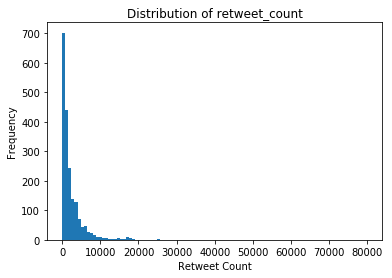

In [47]:
twitter_clean.retweet_count.plot(kind='hist', bins=100);
plt.title('Distribution of retweet_count');
plt.xlabel('Retweet Count');
plt.ylabel('Frequency');

The distribution is right skewed with the bult of retweet counts falls below 10000

###### Distribution of favourite count

In [50]:
twitter_clean.favorite_count.describe()

count      1964.000000
mean       8502.321283
std       12491.513787
min          73.000000
25%        1819.500000
50%        3843.500000
75%       10587.250000
max      159863.000000
Name: favorite_count, dtype: float64

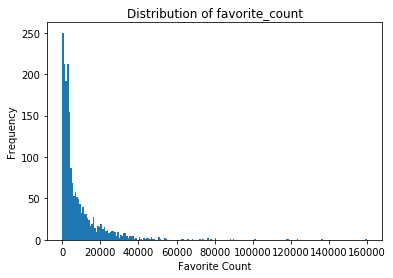

In [51]:
twitter_clean.favorite_count.plot(kind='hist', bins=200);
plt.title('Distribution of favorite_count');
plt.xlabel('Favorite Count');
plt.ylabel('Frequency');

The distribution is right skewed with bulk of favorite count falls below 40000

###### Relationship between favorite count and retweet count

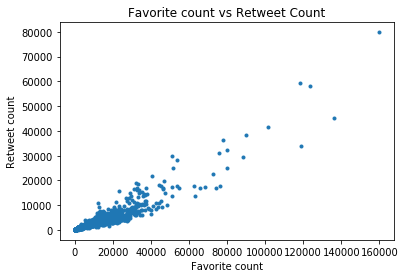

In [52]:
plt.plot(twitter_clean.favorite_count, twitter_clean.retweet_count, marker='o', linestyle='', ms=3 )

plt.title('Favorite count vs Retweet Count');
plt.xlabel('Favorite count');
plt.ylabel('Retweet count');


Favorite count and retweet count seem positively correlated from the scatterplot.

###### Plot the Correlation map to see the relationship between variables

Text(0.5,1,'Correlation Map')

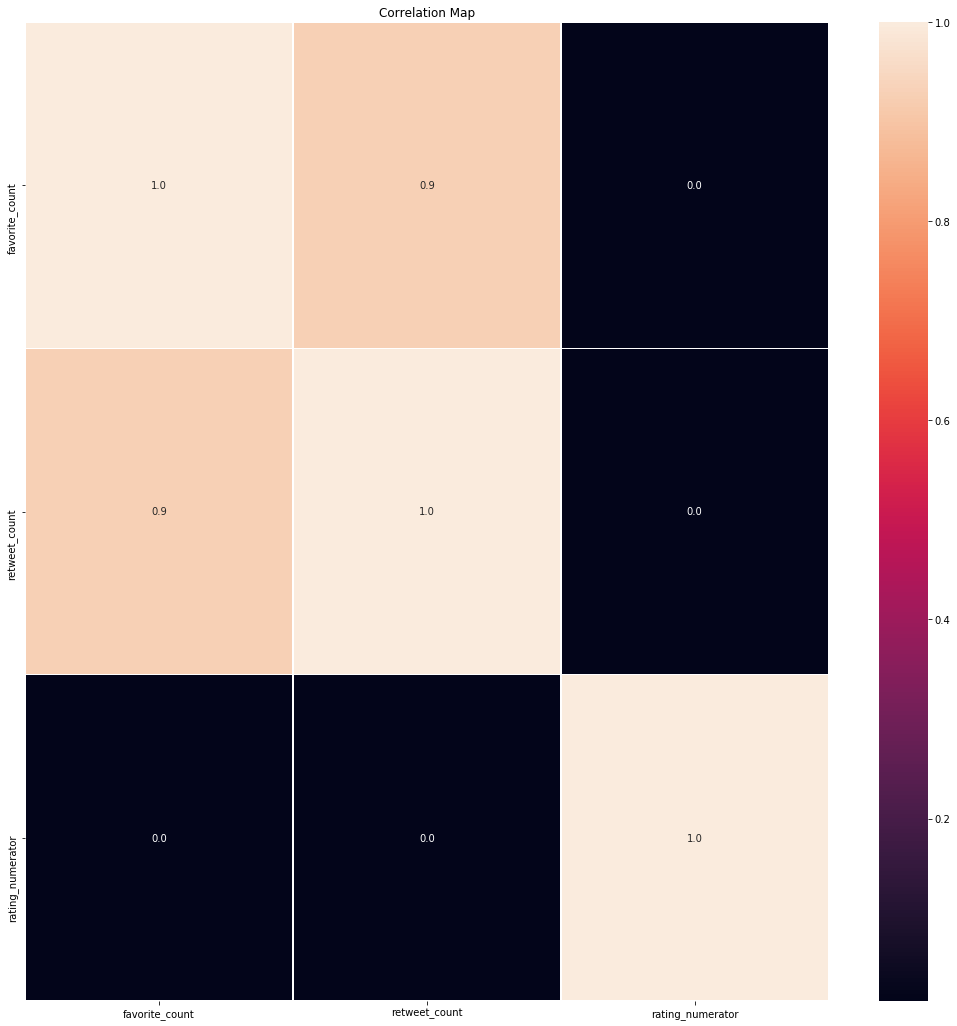

In [59]:
import seaborn as sns
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(twitter_clean[['source', 'favorite_count','retweet_count',
                'rating_numerator']].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Map')

This plot also shows that there is a strong correlation of 0.91 between favorite_count and retweet_count which suggests if people 'like' a tweet they tend to retweet it.

###### Rating system

In [60]:
twitter_clean.rating_numerator.describe()

count    1971.000000
mean       12.223237
std        41.634034
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [61]:
twitter_clean.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       150
8        95
7        52
5        33
14       33
6        32
3        19
4        16
2         9
1         5
1776      1
24        1
26        1
420       1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

From the above , the outliers are 1776 and 420.Hence excluding these for visualization

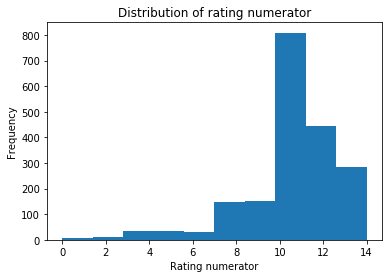

In [63]:
#consider only 0-15 numerator rating values
nrlessthan15 = twitter_clean.rating_numerator[twitter_clean.rating_numerator < 15]
plt.hist(nrlessthan15);
plt.title('Distribution of rating numerator');
plt.xlabel('Rating numerator');
plt.ylabel('Frequency');
plt.figure(figsize=(12,10));

In [67]:
twitter_clean.rating_denominator.value_counts()

10     1954
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

Its a left skewed distribution, with most of the rating occur between 8-14

In [70]:
twitter_clean.set_index('timestamp',inplace=True)

Text(0,0.5,'Rating')

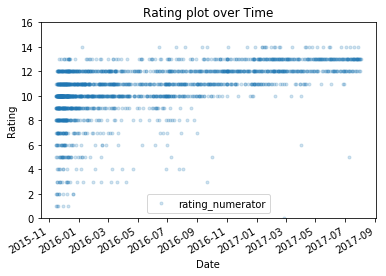

In [71]:
twitter_clean.plot(y ='rating_numerator', ylim=[0,16], style = '.', alpha = .2)
plt.title('Rating plot over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

The page has lesser ratings initially and over the years rating increases then they adapt system of rating numerator more than the denominator.

###### Distribution of dog stage

(-1.2888360004542294,
 1.2369294784909517,
 -1.230849569737158,
 1.2109479647345249)

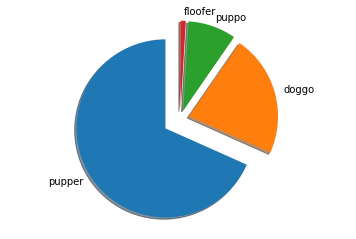

In [74]:
# Plot the data partitioned by dog stage
dog_stage_count = list(twitter_clean[twitter_clean['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]
dog_stages = twitter_clean[twitter_clean['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')

Pupper is the most owned dog.

In [83]:
twitter_clean[twitter_clean['dog_stage'] != 'None'].groupby('dog_stage')['rating_numerator'].mean()

dog_stage
doggo      14.352113
floofer    12.666667
pupper     12.427273
puppo      12.142857
Name: rating_numerator, dtype: float64

Doggo gets the most rating.Puppo gets the least.